In [1]:
import os
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
from fastbook import *

#generator_seed = 12623637008



ssa_names = open('names_1880_To_2022.txt').read().splitlines()

total_number_names = len(ssa_names)
print("total number of names:", total_number_names)
print()

#random.seed(generator_seed) # uncomment if you want the names to always be the same.
print("random sample of 5 names: ", random.choices(ssa_names, k=5))
print()

min_len_word = min(len(w) for w in ssa_names)
max_len_word = max(len(w) for w in ssa_names)
print()

print("min length word:", min_len_word)
print()

print("max length word:", max_len_word)
print()

total number of names: 102449

random sample of 5 names:  ['cauy', 'rajay', 'martile', 'kaan', 'adaryl']


min length word: 2

max length word: 15



In [2]:
shortest_names = [w for w in ssa_names if len(w) <= min_len_word]
print("shortest_names:", shortest_names)

shortest_names: ['ii', 'ja', 'vi', 'od', 'kd', 'ax', 'jd', 'jp', 'st', 'sa', 'rc', 'jt', 'xi', 'ju', 'zy', 'mi', 'kj', 'cj', 'ho', 'se', 'io', 'ge', 'eh', 'jw', 'un', 'kc', 'no', 'an', 'mr', 'va', 'oz', 'du', 'ji', 'ah', 'tr', 'mc', 'si', 'zi', 'ld', 'go', 'pj', 'la', 'qi', 'jm', 'or', 'bj', 'sy', 'lu', 'ao', 'zo', 'su', 'ed', 'xu', 'za', 'ra', 'bb', 'na', 'ry', 'ki', 'pa', 'gy', 'md', 'vu', 'fu', 'ti', 'lj', 'jo', 'ad', 'ej', 'di', 'jl', 'my', 'ku', 'mu', 'lc', 'vy', 'te', 'ar', 'aj', 'ze', 'rb', 'ly', 'jc', 'el', 'so', 'ya', 'ma', 'gi', 'ia', 'yu', 'po', 'li', 'ac', 'lb', 'sj', 'tu', 'ke', 'fe', 'ro', 'kt', 'dj', 'al', 'eb', 'wa', 'mj', 'ab', 'oh', 'rj', 'tc', 'je', 'hy', 'lg', 'yi', 'om', 'yy', 'oc', 'ty', 'me', 'ko', 'av', 'ny', 'ng', 'yo', 'ai', 'jb', 'ka', 'jj', 'ru', 'ea', 'ni', 'ky', 'da', 'rd', 'de', 'le', 'bo', 'do', 'ta', 'rl', 'jr', 'ye', 'in', 'mo', 'ok', 'wc', 'hu', 'wm', 'ha', 'bg', 'ba', 'be', 'lo', 'cy', 'tj', 'en']


In [3]:
longest_names = [w for w in ssa_names if len(w) >= max_len_word]
print("longest_names:", longest_names)

longest_names: ['laurenelizabeth', 'ryanchristopher', 'christianjoseph', 'sophiaelizabeth', 'mariadelosangel', 'michaelchristop', 'ashleyelizabeth', 'johnchristopher', 'muhammadibrahim', 'jordanalexander', 'joshuaalexander', 'christophermich', 'christopherpaul', 'christianmichae', 'christianalexan', 'jonathanmichael', 'christiandaniel', 'davidchristophe', 'gabrielalexande', 'christopherdavi', 'mariadelrosario', 'christopherjose', 'christopherjohn', 'jordanchristoph', 'markchristopher', 'seanchristopher', 'christopheranth', 'kevinchristophe', 'christopherjame', 'jaydenalexander', 'christiananthon', 'christopherryan', 'muhammadmustafa', 'franciscojavier', 'hannahelizabeth', 'christianjoshua', 'matthewalexande']


In [4]:
# tokenizer: the tokens are '.' + lowercase alphabet
tokens = ['.'] + sorted(list(set((''.join(ssa_names)))))
print("tokens:", tokens)
print()

# token to int converter
stoi = {s:i for i,s in enumerate(tokens)} # string to int
print("stoi:", stoi)
print()

# int to token converter
itos = {i:s for s,i in stoi.items()} # int to string
print("itos:", itos)
print()

tokens: ['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

stoi: {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}

itos: {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}



In [5]:
# block size is the context length
def build_dataset(words, block_size = 1, verbose = False): 
    X, Y = [], []
    
    ndex = 0
    num_examples_to_print = 2

    for w in words:
        if verbose and ndex < num_examples_to_print:
            print(w)
            print("input ---> output")
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            if verbose and ndex < num_examples_to_print:
                # pretty print first three names
                print(''.join(itos[i] for i in context), '--->', itos[ix])
                
            context = context[1:] + [ix] # crop and append

        ndex = ndex + 1

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# shuffle the words and then get the training splits
random.shuffle(ssa_names) # mix the words up
n1 = int(0.8*len(ssa_names)) # cut off point for training set
n2 = int(0.9*len(ssa_names)) # cut off for dev set

# build bigram dataset. note second dimension of x is 1. this is the context length (block_size)
words_tr = ssa_names[:n1]
Xtr, Ytr = build_dataset(words_tr, verbose=False) # training set used to update model parameters
print("Xtr shape:", Xtr.shape, "Ytr shape: ", Ytr.shape)
print()

words_dev = ssa_names[n1:n2]
Xdev, Ydev = build_dataset(words_dev, verbose=False) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
print("Xdev shape:", Xdev.shape, "Ydev shape: ", Ydev.shape)
print()

words_te = ssa_names[n2:]
Xte, Yte = build_dataset(words_te, verbose=False) # test set used once or sparingly. report the performance of the model based on this set.
print("Xte shape:", Xte.shape, "Yte shape: ", Yte.shape)
print()

Xtr shape: torch.Size([616758, 1]) Ytr shape:  torch.Size([616758])

Xdev shape: torch.Size([77250, 1]) Ydev shape:  torch.Size([77250])

Xte shape: torch.Size([77021, 1]) Yte shape:  torch.Size([77021])



In [6]:
demo_set = build_dataset(['matt', 'kathy'], block_size = 3, verbose = True)

matt
input ---> output
... ---> m
..m ---> a
.ma ---> t
mat ---> t
att ---> .
kathy
input ---> output
... ---> k
..k ---> a
.ka ---> t
kat ---> h
ath ---> y
thy ---> .


In [7]:
print(demo_set)

(tensor([[ 0,  0,  0],
        [ 0,  0, 13],
        [ 0, 13,  1],
        [13,  1, 20],
        [ 1, 20, 20],
        [ 0,  0,  0],
        [ 0,  0, 11],
        [ 0, 11,  1],
        [11,  1, 20],
        [ 1, 20,  8],
        [20,  8, 25]]), tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))


In [13]:
demo_set = build_dataset(['matt', 'kathy'], block_size = 2, verbose = True)

matt
input ---> output
.. ---> m
.m ---> a
ma ---> t
at ---> t
tt ---> .
kathy
input ---> output
.. ---> k
.k ---> a
ka ---> t
at ---> h
th ---> y
hy ---> .


In [14]:
print(demo_set)

(tensor([[ 0,  0],
        [ 0, 13],
        [13,  1],
        [ 1, 20],
        [20, 20],
        [ 0,  0],
        [ 0, 11],
        [11,  1],
        [ 1, 20],
        [20,  8],
        [ 8, 25]]), tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))


In [15]:
print(demo_set)

(tensor([[ 0,  0],
        [ 0, 13],
        [13,  1],
        [ 1, 20],
        [20, 20],
        [ 0,  0],
        [ 0, 11],
        [11,  1],
        [ 1, 20],
        [20,  8],
        [ 8, 25]]), tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))


In [16]:
demo_set = build_dataset(['matt', 'kathy'], block_size = 1, verbose = True)

matt
input ---> output
. ---> m
m ---> a
a ---> t
t ---> t
t ---> .
kathy
input ---> output
. ---> k
k ---> a
a ---> t
t ---> h
h ---> y
y ---> .


In [17]:
print(demo_set)

(tensor([[ 0],
        [13],
        [ 1],
        [20],
        [20],
        [ 0],
        [11],
        [ 1],
        [20],
        [ 8],
        [25]]), tensor([13,  1, 20, 20,  0, 11,  1, 20,  8, 25,  0]))


In [18]:
# takes X and Y from Build Dataset and Creates a Counts Tensor
# counts_shape is the shape of the tensor for counts
def create_counts(X, Y, counts_shape = (27,27)):
    N = torch.zeros(counts_shape, dtype=torch.int32) # initialize tensor to 0
    for ndx in zip(X, Y):
        ndx = ndx[0].tolist() + [ndx[1].item()]
        N[tuple(ndx)] += 1

    return N

N = create_counts(Xtr, Ytr)
#N_Row_Sum = N.sum(1, keepdim=False)
#print("Sum Row .", N_Row_Sum)

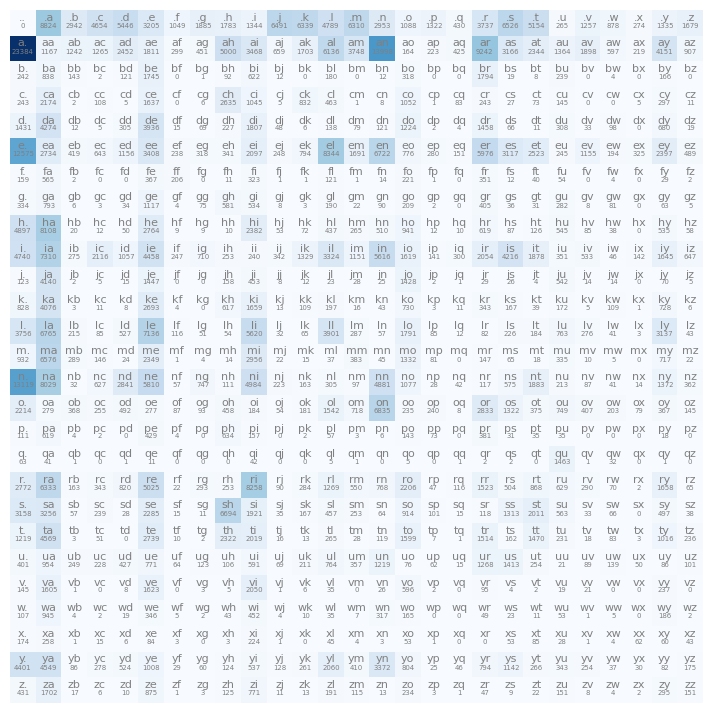

In [19]:
# visuzalize counts
# create image of N to visualize the counts of two character combinations
plt.figure(figsize=(9,9))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j] # every 2 character combination where order matters
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray", fontsize=8)
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray", fontsize=5)
plt.axis('off');
plt.show()

In [20]:
# Add 1 smoothing
smoother =  1 

# Convert rows to 27 multinomial distributions
# Add 1 to N for smoothing. Prevents character combinations with 0 probability.
# We will be using log later, so also prevents log(0) = inf
# Also as if make constant add large the dist approaches uniform.
P = (N+smoother).float() # convert int tensor to floats for prob dist
P/= P.sum(1, keepdim=True) # normalize rows in place

# create a function to sample from the model
def bigram_generate_names(num_names, is_uniform = False):
    g = torch.Generator() #.manual_seed(generator_seed) # random seed for reproducibility

    p = torch.ones(27) / 27.0 # uniform case. every character has 1/27 chance of being chosen.

    for i in range(num_names):
        out = []
        ix = 0 # first letter comes from the first row
        while True:
            if(not is_uniform):
                p = P[ix] # use distribution based on the count date versus flat uniform dist

            # sample from a multinomial distribution. think generalization of coin flipping.
            ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
            out.append(itos[ix])
            if(ix == 0): # went to special "." character which denotes end of name
                break
        print(''.join(out))

bigram_generate_names(10, is_uniform = True)

cybidtwxfbgghyqpydaitupwyaieptdiurwkiezuvieyzlstazjrtexlmcvux.
blvflialotgtqvnzjwanibppg.
ukvdbccyrevvaamslcfmogufjxifsvu.
bvg.
ccxaehgwxgpvnny.
pzntdusncgujmhojonqkxzgwvqnxtxfosufgh.
gmyslosffxafefsggewpcgcaereksfayrowciykdzjwxo.
ovckiykugvmmdjihyovpumhdkcwfgnfydv.
fudfwvgyhmpzjnjwogzlosmuyyqqatphj.
prlzwzzusiaaiaphvtfyqlftjvkcougaur.


In [21]:
bigram_generate_names(10, is_uniform = False)

ce.
iatelfin.
lyntyla.
tua.
aayerttierarie.
maieyn.
sta.
jatahlon.
mi.
be.


In [22]:
def likelihood_calc(words, verbose = False, is_uniform = False):
    log_likelihood = 0
    n = 0

    for w in words:
    #for w in ["matt"]: # can evaluate probability for any word
        chs = ['.'] + list(w) + ['.'] # hallucinate special start and end token to know where word begins an ends
        for ch1, ch2 in zip(chs, chs[1:]): # cute way to get tuples of consecutive chars in word
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            prob = P[ix1, ix2] # prob that the model assigns to the bigram
            if(is_uniform):
                prob = torch.tensor(1.0/len(stoi))

            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1

            if(verbose):
                print(f'{ch1}{ch2}: prob={prob: .4f} logprob={logprob: .4f}')

    #print(f'{log_likelihood=}') # range is 0 to neg inf
    nll = -log_likelihood # negative log likelihood
    #print(f'{nll=}')
    print(f'average negative log likelihood loss={nll/n}') # average log likelihood

# evaluate loss on test set
likelihood_calc(words_te, verbose = False, is_uniform = True)

average negative log likelihood loss=3.296685218811035


In [23]:
likelihood_calc(words_te, verbose = False, is_uniform = False)

average negative log likelihood loss=2.4630987644195557


In [24]:
X_tri_tr, Y_tri_tr = build_dataset(words_tr, block_size=2, verbose=True) # training set used to update model parameters
X_tri_dev, Y_tri_dev = build_dataset(words_dev, block_size=2, verbose=False) # development or validation set used to tune hyper parameters like embedding size or hidden layer size
X_tri_te, Y_tri_te = build_dataset(words_te, block_size=2, verbose=False) # test set used once or sparingly. report the performance of the model based on this set.


rachyl
input ---> output
.. ---> r
.r ---> a
ra ---> c
ac ---> h
ch ---> y
hy ---> l
yl ---> .
kaashi
input ---> output
.. ---> k
.k ---> a
ka ---> a
aa ---> s
as ---> h
sh ---> i
hi ---> .


In [25]:
N_trigram_tr = create_counts(X_tri_tr, Y_tri_tr, (27, 27, 27))
# construct P
P_tri = (N_trigram_tr+1).float() # add 1 to everything for smoothing and to prevent log(0) = inf when calculating the loss
P_tri /= P_tri.sum(2, keepdim=True)
P_tri.shape

torch.Size([27, 27, 27])

In [26]:
# first generation attempt?
g = torch.Generator() #.manual_seed(generator_seed)

for i in range(10):

    out = []
    context = [0,0]
    while True:
        p = P_tri[tuple(context)]

        # bigram not a good model, but try just unifom dist see if better. it definitely looks worse
        # trained bigram model is not great, but gives better results than random
        #p = torch.ones(27) / 27.0

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        context = context[1:] + [ix]

    print(''.join(out))

cy.
intemili.
lyn.
tea.
tu.
vaaye.
taimrayia.
maiele.
sha.
jayahlor.


In [27]:
def trigram_loss(words, P, verbose = False):

    log_likelihood = 0.0
    n = 0

    for w in words:
    #for w in ["matthew"]:
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            prob = P[ix1, ix2, ix3]
            logprob = torch.log(prob)
            log_likelihood += logprob
            n += 1
            #print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

    #print(n)
    #print(f'{log_likelihood=}')
    nll = -log_likelihood
    #print(f'{nll=}')
    #print(f'{nll/n}')
    if verbose:
        print(f'average negative log likelihood loss={nll/n}')
    return (nll/n).item()

loss = trigram_loss(words_te, P_tri, verbose=true)

average negative log likelihood loss=2.1478989124298096


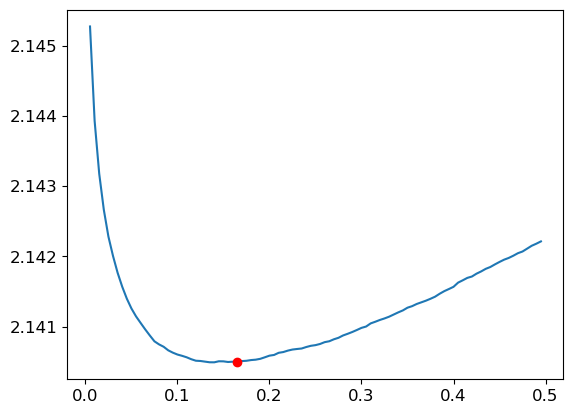

In [28]:
loss = []
smooth = []
for i in range(1,100):
    s = 0.005 * i
    P = (N_trigram_tr + s).float() # add 1 to everything for smoothing and to prevent log(0) = inf when calculating the loss
    P /= P.sum(2, keepdim=True)
    smooth.append(s)
    loss.append(trigram_loss(words_dev, P))

index_min = np.argmin(loss)
#index_min
best_smoother = smooth[index_min]
#best_smoother

plt.plot(smooth, loss)
# https://stackoverflow.com/questions/44505762/how-to-plot-additional-points-on-the-top-of-scatter-plot
plt.plot(best_smoother, loss[index_min], "or")

In [29]:
P_tri = (N_trigram_tr+best_smoother).float() # add 1 to everything for smoothing and to prevent log(0) = inf when calculating the loss
P_tri /= P_tri.sum(2, keepdim=True)

loss = trigram_loss(words_te, P_tri, verbose=true)

average negative log likelihood loss=2.1425273418426514


In [30]:
g = torch.Generator() #.manual_seed(generator_seed)

for i in range(10):

    out = []
    context = [0,0]
    while True:
        p = P_tri[tuple(context)]

        # bigram not a good model, but try just unifom dist see if better. it definitely looks worse
        # trained bigram model is not great, but gives better results than random
        #p = torch.ones(27) / 27.0

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
        context = context[1:] + [ix]

    print(''.join(out))

cy.
intemili.
lyn.
tea.
tu.
vaaye.
taimrayia.
maiele.
sha.
jayahlor.
